In [7]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

incomes = np.loadtxt('incomes.txt', delimiter = ',', unpack = True)

# Problem 1
## (a)

<IPython.core.display.Javascript object>


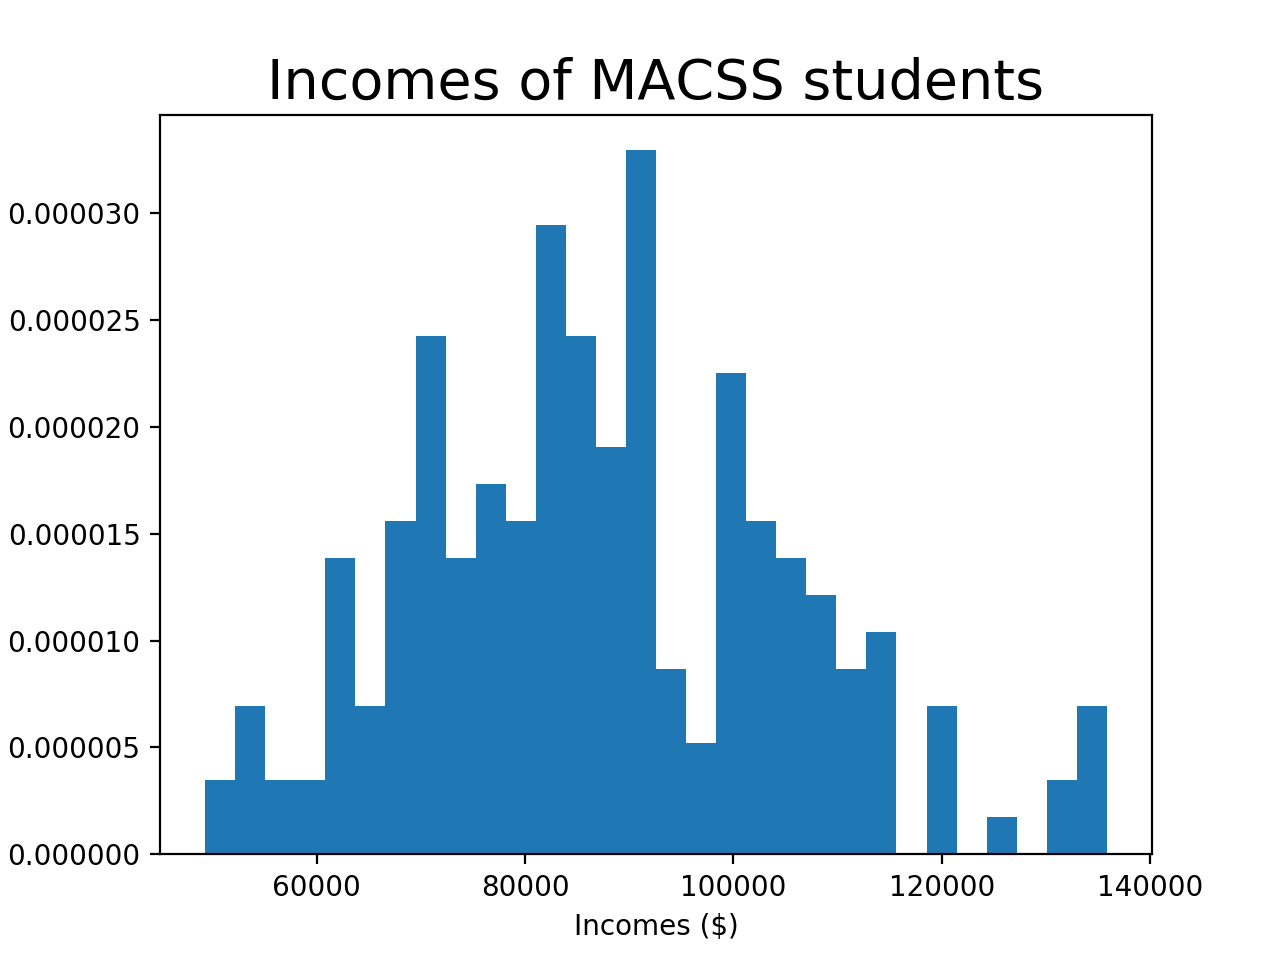

Text(0,0.5,'Percent of observations')

In [8]:
#part a
plt.hist(incomes, 30, normed=True)
plt.title('Incomes of MACSS students', fontsize = 20)
plt.xlabel(r'Incomes (\$)')
plt.ylabel('Percent of observations')

## (b)

In [10]:
# part b
# Define function that generates values of a potentially trucated normal
# probability density function (PDF)
def trunc_lognorm_pdf(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the log normal pdf with mean mu and standard
    deviation sigma. If the cutoff is given, then the PDF values are
    inflated upward to reflect the zero probability on values above the
    cutoff. If there is no cutoff given, this function does the same
    thing as sp.stats.lognorm.pdf(x, loc=mu, s=sigma, scale = 1).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the log-normally distributed random
             variable
    mu     = scalar, mean of the log-normally distributed random variable
    sigma  = scalar > 0, standard deviation of the log-normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(0, loc=mu, s=sigma, scale=1)
    else:
        prob_notcut = (sts.lognorm.cdf(cutoff, loc=mu, s=sigma, scale=1) -
                       sts.lognorm.cdf(0, loc=mu, s=sigma, scale=1))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [11]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), std(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, incomes data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    std_data  = scalar > 0, standard deviation of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data



In [12]:
def model_moments(mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_lognorm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    std_model  = scalr > 0, standard deviation of the distribution
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, std_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0.01, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0.01, cutoff)
    std_model = math.sqrt(var_model)
    return mean_model, std_model


In [13]:
def err_vec(xvals, mu, sigma, cutoff, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the log normally distributed random variable
    sigma  = scalar > 0, standard deviation of the log normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [14]:
def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val


In [27]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes, 150000.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((0.01, None), (0.01, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.3660508069  sig_GMM1= 0.208759124989


In [28]:
mean_data, std_data = data_moments(incomes)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 150000.0)
err1 = err_vec(incomes, mu_GMM1, sig_GMM1, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard deviation of points =', std_data)
print('Mean of model =', mean_model, ', Standard deviation of model =', std_model)
print('Error vector=', err1)
results


Mean of points = 87588.9307685 , Standard deviation of points = 18035.9068271
Mean of model = 87588.9323714689 , Standard deviation of model = 18035.907142232958
Error vector= [  1.83009026e-08   1.74729574e-08]


      fun: array([[  6.40227273e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.87225884e-08,   3.11974621e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 42
      nit: 9
   status: 0
  success: True
        x: array([ 11.36605081,   0.20875912])

## (c)

In [29]:
#c 
err1 = err_vec(incomes, mu_GMM1, sig_GMM1, 150000.0, False)
VCV2 = np.dot(err1, err1.T) / incomes.shape[0]
print(VCV2)
W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2)

[[  1.67461517e-18   1.59885445e-18]
 [  1.59885445e-18   1.52652119e-18]]
[[  1.63420551e+17   1.56027295e+17]
 [  1.56027295e+17   1.48968515e+17]]


In [30]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (incomes, 150000.0, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((0.1, None), (0.1, None)))
mu_GMM2, sig_GMM2 = results.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2, 'criterion=', 
      criterion(([mu_GMM2, sig_GMM2]), incomes, 150000, W_hat2))

mu_GMM2= 11.3660507827  sig_GMM2= 0.208759124756 criterion= [[ 1.48472044]]


<IPython.core.display.Javascript object>


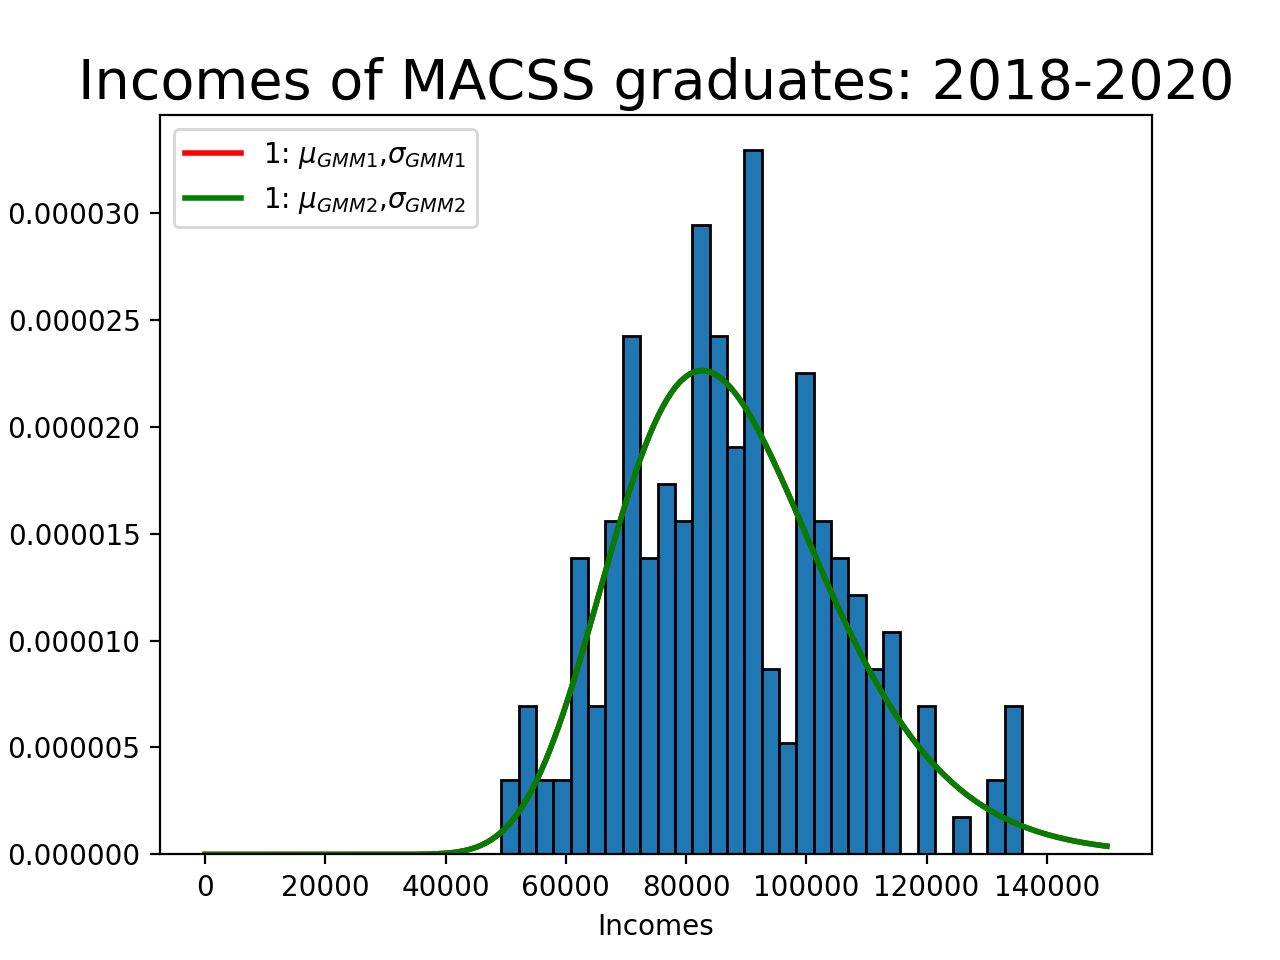

In [16]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Incomes of MACSS graduates: 2018-2020', fontsize=20)
plt.xlabel('Incomes')
plt.ylabel('Percent of graduates')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0.01, 150000, 200)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 150000),
         linewidth=2, color='g', label='1: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')

In [18]:
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 150000.0)
print("The data mean is:", mean_data,"\n" 
      "The data standard deviation is:", std_data, "\n" 
     "Mean of the first model is:", mean_model, "\n"
      "Standard deviation of the first model is:", std_model, "\n" 
     "Mean of the second model is:", mean_model2, "\n"
     "Standard deviation of the second model is:", std_model2)

The data mean is: 87588.9307685 
The data standard deviation is: 18035.9068271 
Mean of the first model is: 87588.9323714689 
Standard deviation of the first model is: 18035.907142232958 
Mean of the second model is: 87588.9304656648 
Standard deviation of the second model is: 18035.906835468813


## (d)

In [15]:
def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the four data moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < 75000
    bpct_2_dat = scalar in [0, 1], percent of observations
                 75000 <= x < 100000
    bpct_3_dat = scalar in [0, 1], percent of observations
                 100000 <= x < 150000
  

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[(xvals >= 0.1) & (xvals < 75000.0)].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000.0) & (xvals < 100000.0)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >=100000.0) & (xvals < 150000.0)].shape[0] /
                  xvals.shape[0])

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [16]:
def model_moments3(mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    This function computes the three model moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bp_1_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_1_mod
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bp_2_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_2_mod
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3
    bp_3_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_3_mod
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod
    --------------------------------------------------------------------
    '''
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.1, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


In [17]:
def err_vec3(xvals, mu, sigma, cutoff, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, incomes data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments3()
        model_moments3()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec

In [18]:
def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (3, 1) matrix, column vector of four moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec3(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val


In [19]:
print(data_moments(incomes))
print(model_moments3(11, 0.5, 150000))
params = np.array([11, 0.5])
print(criterion3(params, incomes, 150000.0, np.eye(3)))

(87588.930768512408, 18035.906827092327)
(0.6738202596154481, 0.17369881270011803, 0.11935982252695118)
[[ 30749.36912046]]


In [20]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
# W_hat[1, 1] = 2.0
# W_hat[2, 2] = 2.0
gmm_args = (incomes, 150000.0, W_hat)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((0.1, None), (0.1, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)

mu_GMM1_3= 11.3702298295  sig_GMM1_3= 0.228974790937


<IPython.core.display.Javascript object>


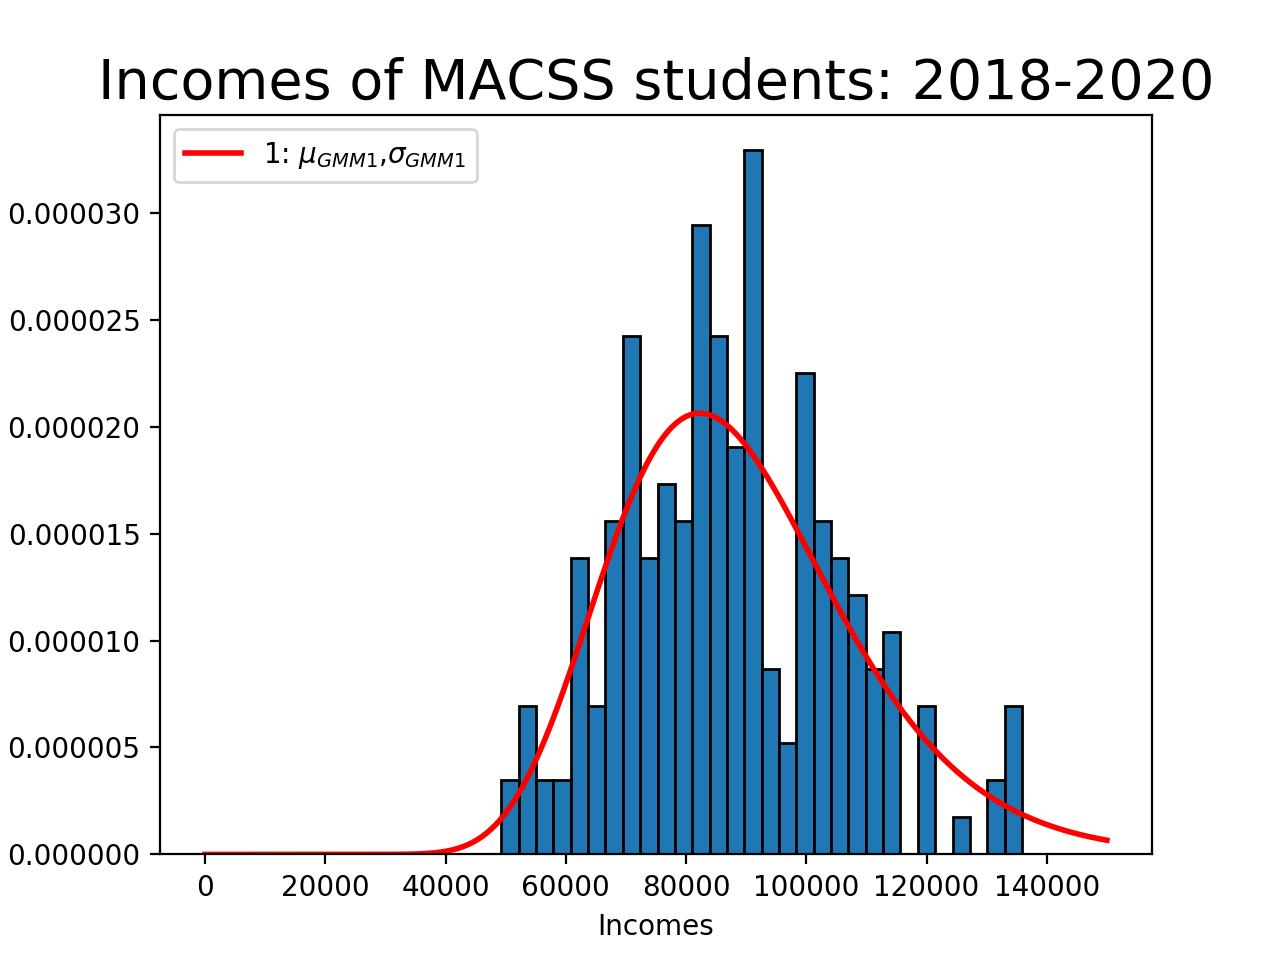

In [60]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Incomes of MACSS students: 2018-2020', fontsize=20)
plt.xlabel('Incomes')
plt.ylabel('Percent of studens')
# This gives the xmin and xmax to be plotted"

# Plot the estimated GMM PDF
dist_pts = np.linspace(0.1, 150000, 200)
plt.plot(dis_pts, trunc_lognorm_pdf(dist_pts, mu_GMM))
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 200),
         linewidth=2, color='r', label='3: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')

In [21]:
crit_val_3 = criterion3(([mu_GMM1_3, sig_GMM1_3]), 
                        incomes, 150000, W_hat)
print("The value of the GMM criterion function at mu =", mu_GMM1_3, 
      "sigma =", sig_GMM1_3, "is:", crit_val_3, "\n")
data_75000, data_75000_100000, data_100000 = \
data_moments3(incomes)
model_75000, model_75000_100000, model_100000 = \
model_moments3(mu_GMM1_3, sig_GMM1_3, 150000)
print("Percentage of students in the data with incomes less than \$75000 is:", 
     data_75000, ", with incomes between $75000 and $100000 is:", 
     data_75000_100000, ", with incomes greater than $100000 is:", 
     data_100000, "\n")
print("Percentage of students in the model with incomes less than $75000 is:",
     model_75000, ", with incomes between $75000 and $100000 is:",
     model_75000_100000, ", with incomes greater than $100000 is:", 
     model_100000, "\n")

The value of the GMM criterion function at mu = 11.3702298295 sigma = 0.228974790937 is: [[ 1.92180502]] 

Percentage of students in the data with incomes less than \$75000 is: 0.265 , with incomes between $75000 and $100000 is: 0.475 , with incomes greater than $100000 is: 0.26 

Percentage of students in the model with incomes less than $75000 is: 0.2633020941161623 , with incomes between $75000 and $100000 is: 0.470119268512549 , with incomes greater than $100000 is: 0.25824527619742904 



## (e)

In [22]:
err1_3 = err_vec3(incomes, mu_GMM1_3, sig_GMM1_3, 150000, False)
VCV2_3 = np.dot(err1_3, err1_3.T) / incomes.shape[0]
print(VCV2_3)
W_hat2_3 = lin.pinv(VCV2_3)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2_3)

[[ 0.00205261  0.00329177  0.00216209]
 [ 0.00329177  0.00527901  0.00346734]
 [ 0.00216209  0.00346734  0.00227741]]
[[ 22.23037706  35.6508916   23.41609703]
 [ 35.6508916   57.17339246  37.55243263]
 [ 23.41609703  37.55243263  24.66506072]]


In [23]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args = (incomes, 150000.0, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((0.1, None), (0.1, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
print('mu_GMM2_3=', mu_GMM2_3, ' sig_GMM2_3=', sig_GMM2_3, 'crit_val=', 
      criterion3(([mu_GMM2_3, sig_GMM2_3]), incomes, 150000, W_hat2_3))
results2_3

mu_GMM2_3= 11.3702358673  sig_GMM2_3= 0.228978051312 crit_val= [[ 199.9999996]]


      fun: array([[ 199.9999996]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.16222543,  1.4239987 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 15
      nit: 1
   status: 0
  success: True
        x: array([ 11.37023587,   0.22897805])

<IPython.core.display.Javascript object>


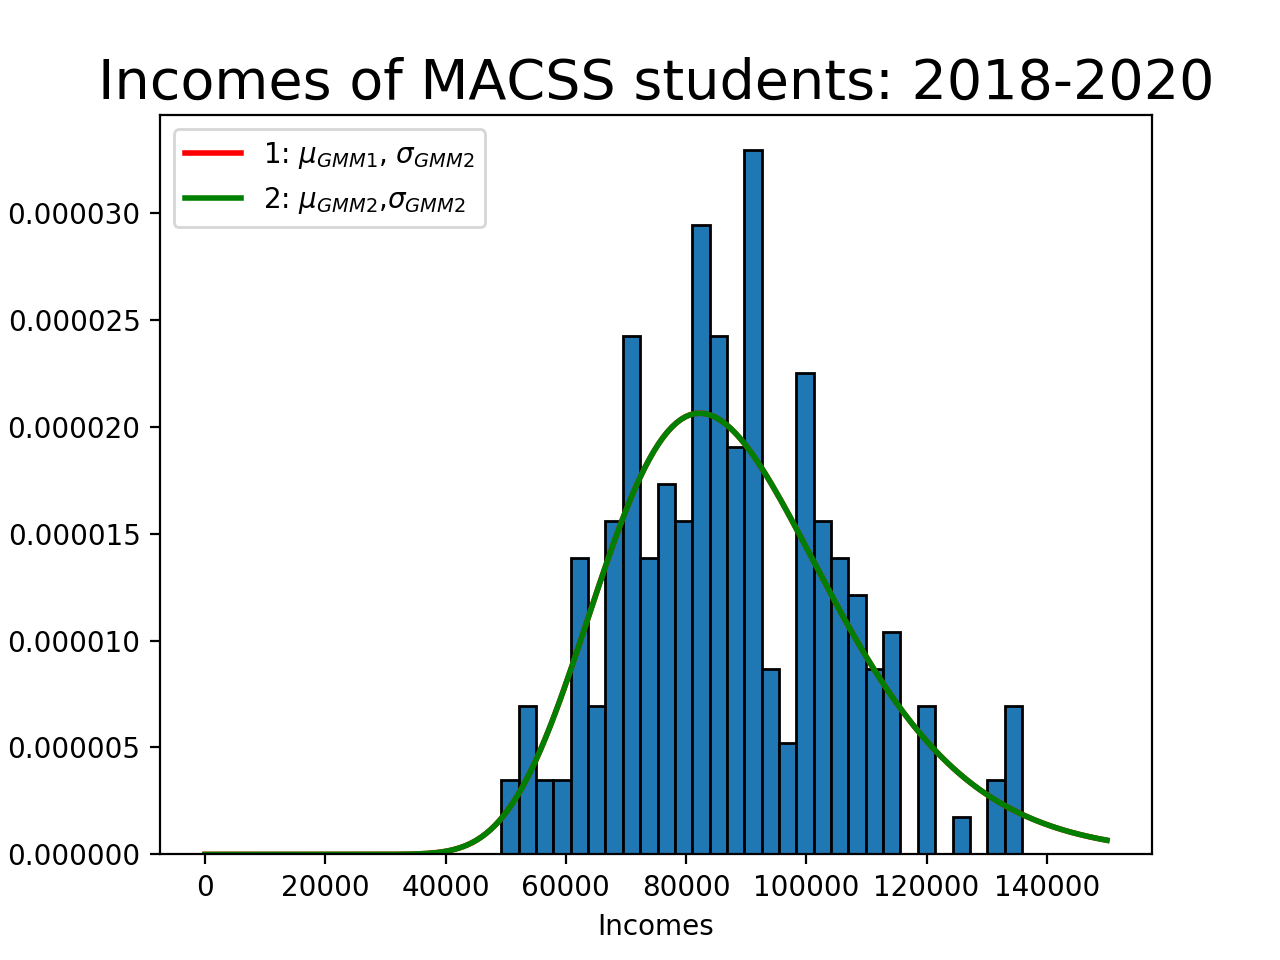

In [25]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Incomes of MACSS students: 2018-2020', fontsize=20)
plt.xlabel('Incomes')
plt.ylabel('Percent of studens')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0.1, 150000, 200)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 200),
        linewidth=2, color='r', label='1: $\mu_{GMM1}$, $\sigma_{GMM2}$')
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2_3, sig_GMM2_3, 200),
         linewidth=2, color='g', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')

In [73]:
crit_val2_3 = criterion3(([mu_GMM2_3, sig_GMM2_3]), 
                        incomes, 150000, W_hat)
print("The value of the GMM criterion function at mu =", mu_GMM2_3, 
      "sigma =", sig_GMM2_3, "is:", crit_val2_3, "\n")
data_75000, data_75000_100000, data_100000 = \
data_moments3(incomes)
model2_75000, model2_75000_100000, model2_100000 = \
model_moments3(mu_GMM2_3, sig_GMM2_3, 150000)
print("Percentage of students in the data with incomes less than $75000 is:", 
     data_75000, ", with incomes between $75000 and $100000 is:", 
     data_75000_100000, ", with incomes greater than $100000 is:", 
     data_100000, "\n")
print("Percentage of students in the model with incomes less than $75000 is:",
     model2_75000, ", with incomes between $75000 and $100000 is:",
     model2_75000_100000, ", with incomes greater than $100000 is:", 
     model2_100000, "\n")

The value of the GMM criterion function at mu = 11.3702358673 sigma = 0.228978051312 is: [[ 1.92182654]] 

Percentage of students in the data with incomes less than $75000 is: 0.265 , with incomes between $75000 and $100000 is: 0.475 , with incomes greater than $100000 is: 0.26 

Percentage of students in the model with incomes less than $75000 is: 0.263296429064053 , with incomes between $75000 and $100000 is: 0.4701133553713098 , with incomes greater than $100000 is: 0.25825548072975074 



## (f)

<IPython.core.display.Javascript object>


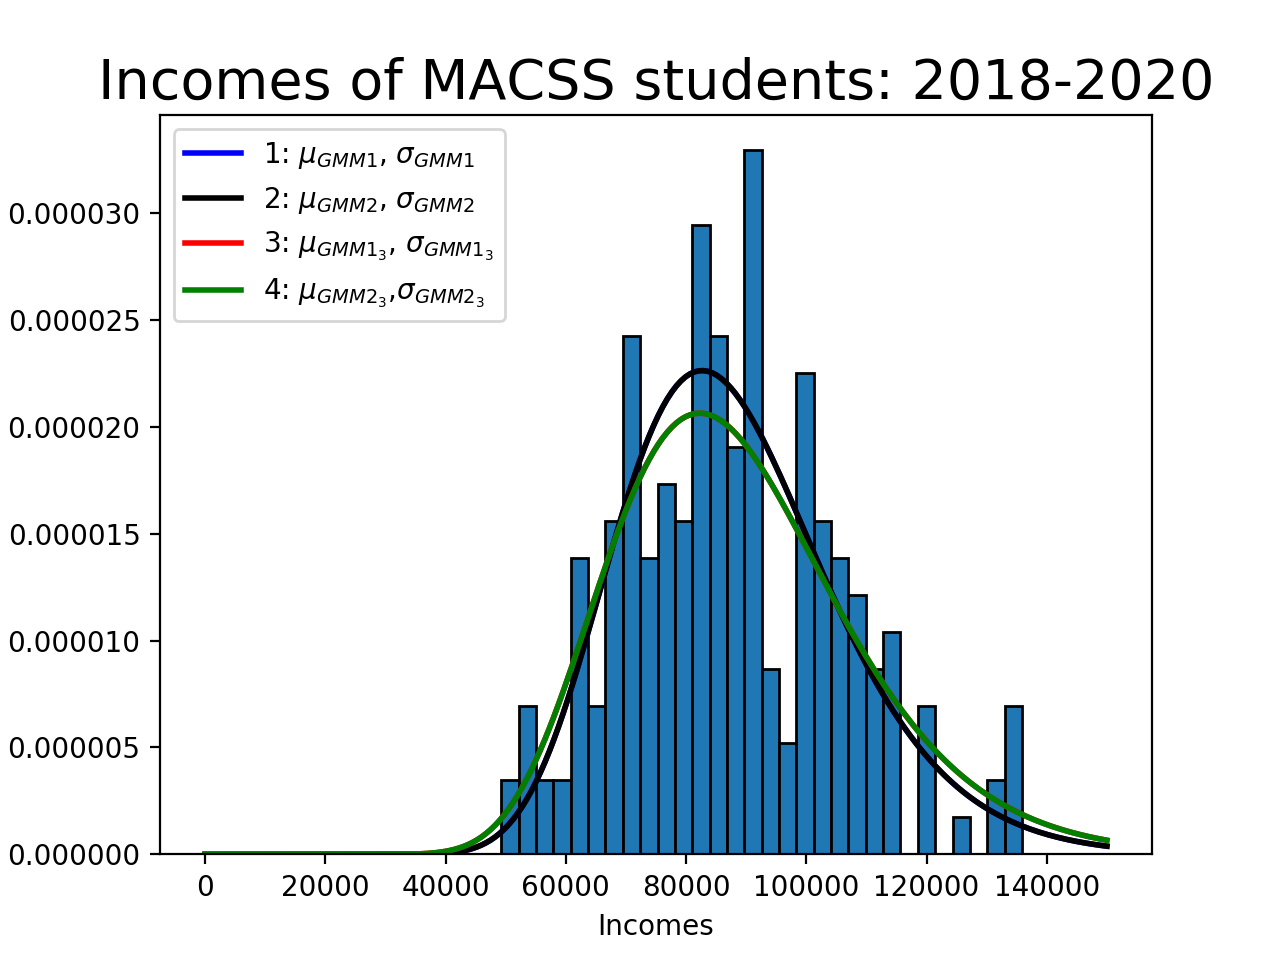

In [32]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Incomes of MACSS students: 2018-2020', fontsize=20)
plt.xlabel('Incomes')
plt.ylabel('Percent of studens')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0.1, 150000, 200)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 200), 
        linewidth=2, color='b', label='1: $\mu_{GMM1}$, $\sigma_{GMM1}$')
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 200), 
        linewidth=2, color='k', label='2: $\mu_{GMM2}$, $\sigma_{GMM2}$')
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 200),
        linewidth=2, color='r', label='3: $\mu_{GMM1_3}$, $\sigma_{GMM1_3}$')
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2_3, sig_GMM2_3, 200),
         linewidth=2, color='g', label='4: $\mu_{GMM2_3}$,$\sigma_{GMM2_3}$')
plt.legend(loc='upper left')

All models are very similar in their results as well as in the plot. I would choose the model in part(c), since the value of its criterion function is the smallest. 

# Problem 2
## (a)

In [33]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib notebook

sick, age, children, temp = np.loadtxt('sick.txt', delimiter = ',', 
                                      skiprows = 1, unpack = True)

In [34]:
def model_moments200(age_vals, children_vals, temp_vals, 
                     beta_0, beta_1, beta_2, beta_3):
    '''
    This function computes the 200 model moments for GMM(beta_0, 
    beta_1, beta_2, beta_3)
    
    INPUTS: 
    age_vals = np.array, age values
    children_vals = np.array, numbers of children
    temp_vals = np.array, average temperature values
    beta_0 = scalar, intercept of the linear regression
    beta_1 = scalar, coefficient of age
    beta_2 = scalar, coefficient of number of children
    beta_3 = scalar, coefficient of average temparture
    
    RETURNS: sick_model
    '''
    sick_model = beta_0 + beta_1 * age_vals + \
        beta_2 * children_vals + beta_3 * temp_vals
    
    return sick_model
    
        

In [35]:
def error_vec200(sick_vals, age_vals, children_vals, temp_vals, 
                beta_0, beta_1, beta_2, beta_3, simple): 
    '''
    This function computes the vector of moment errors (in simple difference
    from the data moment vector) for GMM. 
    
    INPUTS: 
    sick_vals = (N,) np.array, sick days data
    age_vals = (N,) np.array, age data
    children_vals = (N,) np.array, children data
    temp_vals = (N,) np.array, average temperature data
    beta_0 = scalar, intercept of the linear regression
    beta_1 = scalar, coefficient of age
    beta_2 = scalar, coefficient of children
    beta_3 = scalar, coefficient of average temperature
    
    OTHER FUNCTIONS CALLED: 
    model_moments200()
    
    RETURNS: error_vec
    '''
    moms_data = sick_vals
    moms_model = model_moments200(age_vals, children_vals, temp_vals, 
                                 beta_0, beta_1, beta_2, beta_3)
    if simple == True: 
        error_vec = moms_model - moms_data
    else: 
        error_vec = 100 * (moms_model - moms_data) / moms_data
    return error_vec

In [36]:
def criterion200(params, *args): 
    '''
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given the parameter values and an estimage of 
    the weighting matrix. 
    
    INPUTS: 
    params = (4,), vector, ([beta_0, beta_1, beta_2, beta_3])
    beta_0 = scalar, intercept of the linear regression
    beta_1 = scalar, coefficient of age
    beta_2 = scalar, coefficient of children
    beta_4 = scalar, coefficient of temp
    args = length 5 tuple, (sick_vals, age_vals, children_vals, 
    temp_vals, W)
    sick_vals = (N,) np.array, sick days data
    age_vals = (N,) np.array, age data
    children_vals = (N,) np.array, children data
    temp_vals = (N,) np.array, average temperature data
    W = np.array, weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: 
    error_vec()
    
    RETURNS: crit_val
    '''
    beta_0, beta_1, beta_2, beta_3 = params
    sick_vals, age_vals, children_vals, temp_vals, W = args
    err = error_vec200(sick_vals, age_vals, children_vals, temp_vals, 
                      beta_0, beta_1, beta_2, beta_3, simple = True)
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val

In [37]:
beta_0_init = 0.2
beta_1_init = 0.01
beta_2_init = 0.4
beta_3_init = 0
params_init = np.array([beta_0_init, beta_1_init, beta_2_init, beta_3_init])
W_hat = np.eye(200)
gmm_args = sick, age, children, temp, W_hat
bnds = ((None, None), (None, None), 
       (None, None), (None, None))
results_200 = opt.minimize(criterion200, params_init, args=(gmm_args), 
                          method = 'L-BFGS-B', bounds=bnds)
beta_0_GMM, beta_1_GMM, beta_2_GMM, beta_3_GMM = results_200.x
print("The GMM estimations are:\n", "beta_0 =", beta_0_GMM, "\n"
      "beta_1 =", beta_1_GMM, "\n", "beta_2 =", beta_2_GMM, "\n"
     "beta_3 =", beta_3_GMM, "\n", "GMM crit function value is:", 
     criterion200(([beta_0_GMM, beta_1_GMM, beta_2_GMM, beta_3_GMM]), 
                 sick, age, children, temp, W_hat))
results_200

The GMM estimations are:
 beta_0 = 0.251644741364 
beta_1 = 0.0129334519999 
 beta_2 = 0.400501171019 
beta_3 = -0.00999169650594 
 GMM crit function value is: 0.00182128981711


      fun: 0.0018212898171127787
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.68085379e-08,   4.16637211e-07,  -1.27263651e-07,
        -3.63641409e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 80
      nit: 9
   status: 0
  success: True
        x: array([ 0.25164474,  0.01293345,  0.40050117, -0.0099917 ])